In [ ]:

# TRATAMIENTO DE DATOS CORRECTO PARA LSTM AUTOENCODER
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# 1️⃣ Cargar dataset
data = pd.read_csv(r"C:\AA2 - Segundo Avance - Deteccion-de-fraude-inmobiliario\data\data\credit_card_balance.csv")

print("✅ Dataset cargado:", data.shape)

# Eliminar columnas con más del 40% de valores nulos
data = data.loc[:, data.isnull().mean() < 0.4]

# Tratar valores faltantes
# Numéricas → reemplazo por la mediana
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# Categóricas → reemplazo por el valor más frecuente (moda)
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Codificar variables categóricas (LabelEncoder)
encoder = LabelEncoder()
for col in cat_cols:
    data[col] = encoder.fit_transform(data[col])

# Escalar todas las columnas numéricas
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)

print("✅ Datos limpios y escalados:", X_scaled.shape)
print("Columnas procesadas:", len(num_cols) + len(cat_cols))


✅ Dataset cargado: (3840312, 23)
✅ Datos limpios y escalados: (3840312, 23)
Columnas procesadas: 23


In [ ]:

# CONVERTIR A FORMATO SECUENCIAL

# Definir cantidad de pasos y variables (ajusta según tu caso)
n_steps = 24       # pasos temporales (por ejemplo, meses)
n_features = X_scaled.shape[1]  # número de columnas (variables)
samples = X_scaled.shape[0] // n_steps  # cantidad de secuencias completas

# Recortar el exceso y dar forma 3D
X_seq = X_scaled[:samples * n_steps].reshape(samples, n_steps, n_features)

print(f"Datos listos para LSTM: {X_seq.shape} (muestras, pasos, variables)")


✅ Datos listos para LSTM: (160013, 24, 23) (muestras, pasos, variables)


In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping

# Definir arquitectura
timesteps = X_seq.shape[1]
features = X_seq.shape[2]

input_layer = Input(shape=(timesteps, features))
encoder = LSTM(64, activation='tanh')(input_layer)
bottleneck = RepeatVector(timesteps)(encoder)
decoder = LSTM(64, activation='tanh', return_sequences=True)(bottleneck)
output = LSTM(features, activation='linear', return_sequences=True)(decoder)

autoencoder = Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenamiento con early stopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_seq, X_seq,
    epochs=60,
    batch_size=128,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

# Calcular errores de reconstrucción
reconstructed = autoencoder.predict(X_seq)
mse = np.mean(np.square(X_seq - reconstructed), axis=(1, 2))

# Definir umbral dinámico 
umbral = np.percentile(mse, 99)
anomalos = (mse > umbral).astype(int)

print(f"✅ Umbral dinámico: {umbral:.4f}")
print(f"🔸 Casos anómalos detectados: {np.sum(anomalos)} / {len(anomalos)}")

# 5. Guardar resultados
resultados = pd.DataFrame({
    "ID": np.arange(len(mse)),
    "ERROR_RECONSTRUCCION": mse,
    "ANOMALO": anomalos
})
resultados.to_csv("results/lstm_autoencoder_results.csv", index=False)


Epoch 1/60
1001/1001 [==============================] - 39s 35ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 2/60
1001/1001 [==============================] - 35s 35ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 3/60
1001/1001 [==============================] - 34s 34ms/step - loss: 0.0088 - val_loss: 0.0084
Epoch 4/60
1001/1001 [==============================] - 36s 36ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 5/60
1001/1001 [==============================] - 35s 35ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 6/60
1001/1001 [==============================] - 38s 38ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 7/60
1001/1001 [==============================] - 41s 41ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 8/60
1001/1001 [==============================] - 40s 40ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 9/60
1001/1001 [==============================] - 40s 40ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 10/60
1001/1001 [==============================] - 40s 40m

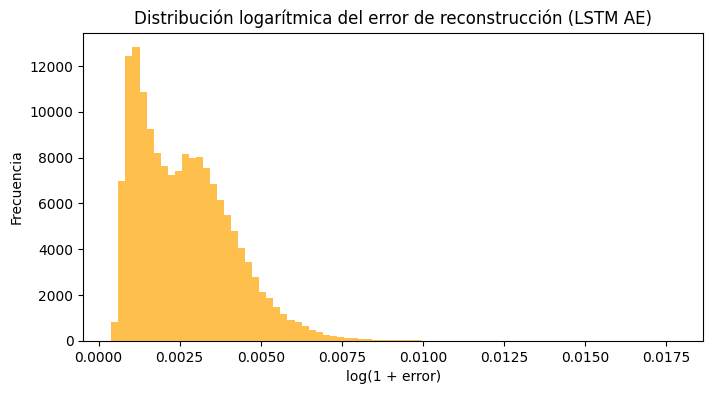

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(np.log1p(mse), bins=80, color="orange", alpha=0.7)
plt.title("Distribución logarítmica del error de reconstrucción (LSTM AE)")
plt.xlabel("log(1 + error)")
plt.ylabel("Frecuencia")
plt.show()


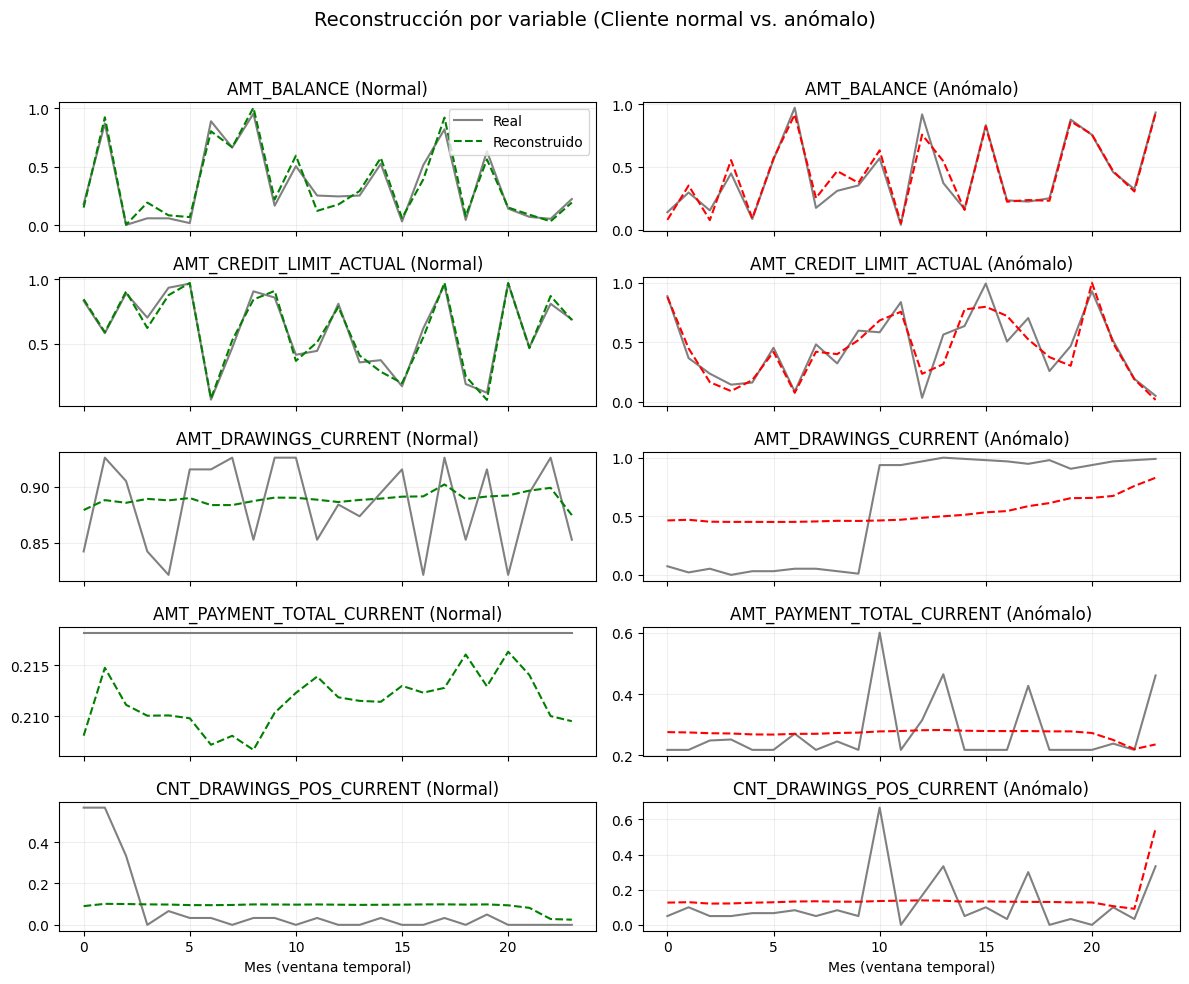

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Variables reales (ajusta según tus columnas)
variables = [
    "AMT_BALANCE",
    "AMT_CREDIT_LIMIT_ACTUAL",
    "AMT_DRAWINGS_CURRENT",
    "AMT_PAYMENT_TOTAL_CURRENT",
    "CNT_DRAWINGS_POS_CURRENT"
]

# Selecciona un cliente normal y otro anómalo (ya los tienes)
t = np.arange(seq_normal.shape[0])

fig, axes = plt.subplots(len(variables), 2, figsize=(12, 10), sharex=True)
fig.suptitle("Reconstrucción por variable (Cliente normal vs. anómalo)", fontsize=14)

for i, var in enumerate(variables):
    # Cliente normal
    axes[i, 0].plot(t, seq_normal[:, i], color="gray", label="Real")
    axes[i, 0].plot(t, recon_normal[:, i], color="green", linestyle="--", label="Reconstruido")
    axes[i, 0].set_title(f"{var} (Normal)")
    axes[i, 0].grid(alpha=0.2)

    # Cliente anómalo
    axes[i, 1].plot(t, seq_anomalo[:, i], color="gray", label="Real")
    axes[i, 1].plot(t, recon_anomalo[:, i], color="red", linestyle="--", label="Reconstruido")
    axes[i, 1].set_title(f"{var} (Anómalo)")
    axes[i, 1].grid(alpha=0.2)

for ax in axes[-1, :]:
    ax.set_xlabel("Mes (ventana temporal)")

axes[0, 0].legend(loc="upper right")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


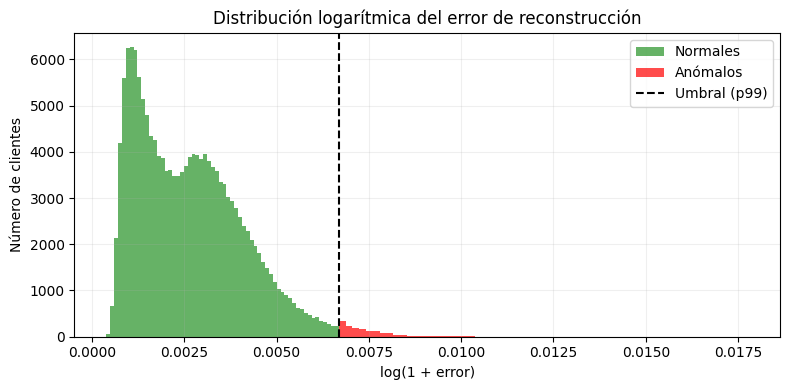

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,4))
plt.hist(np.log1p(mse[anomalos == 0]), bins=60, color="green", alpha=0.6, label="Normales")
plt.hist(np.log1p(mse[anomalos == 1]), bins=60, color="red", alpha=0.7, label="Anómalos")
plt.axvline(np.log1p(umbral), color="black", linestyle="--", label="Umbral (p99)")
plt.title("Distribución logarítmica del error de reconstrucción")
plt.xlabel("log(1 + error)")
plt.ylabel("Número de clientes")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


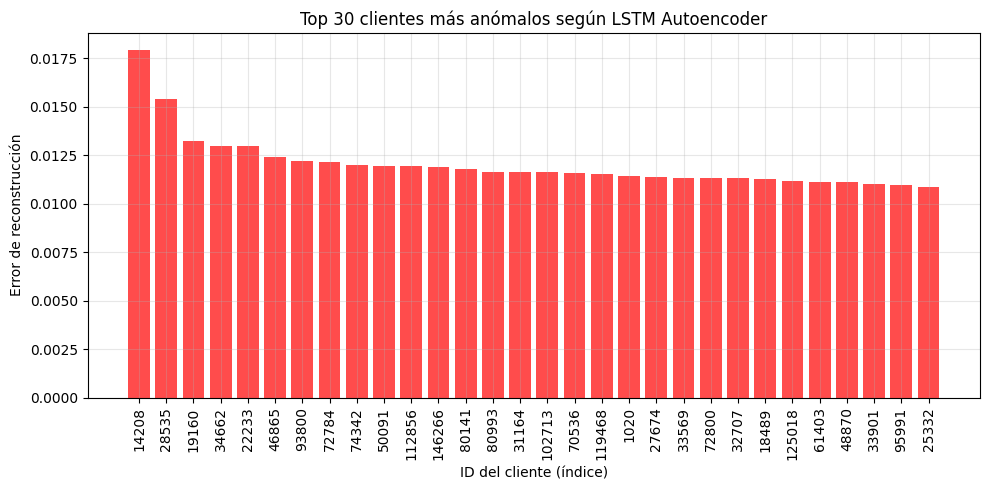

In [40]:
# Crear ranking de los 30 más anómalos
top_n = 30
ranking = pd.DataFrame({
    "Cliente": np.arange(len(mse)),
    "Error": mse
}).sort_values("Error", ascending=False).head(top_n)

plt.figure(figsize=(10,5))
plt.bar(ranking["Cliente"].astype(str), ranking["Error"], color="red", alpha=0.7)
plt.xticks(rotation=90)
plt.title(f"Top {top_n} clientes más anómalos según LSTM Autoencoder")
plt.ylabel("Error de reconstrucción")
plt.xlabel("ID del cliente (índice)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [47]:
print("Media error:", np.mean(mse))
print("Percentil 95:", np.percentile(mse, 95))
print("Percentil 99:", np.percentile(mse, 99))
print("Número de anómalos detectados:", np.sum(anomalos))


Media error: 0.0026476056768572377
Percentil 95: 0.005287410189336038
Percentil 99: 0.006705728224959465
Número de anómalos detectados: 1601
